Adam  是 一 个 结 合 了 动 量 法 和  RMSPr op  的 优 化 算 法 ， 其 结 合 了 两 者 的 优 点 。

In [1]:
from __future__ import  division
from __future__ import  absolute_import
from __future__ import print_function

import tensorflow as tf
import numpy as np
import time
import tensorflow.examples.tutorials.mnist.input_data as input_data

import sys

tf.set_random_seed(2019)

mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

train_set = mnist.train
test_set = mnist.test

def hidden_layer(layer_input, output_depth, scope = "hidden_layer", reuse=None,weights_collection=None, 
                 biases_collection=None):
    input_depth = layer_input.get_shape()[-1]
    with tf.variable_scope(scope, reuse=reuse):
        w = tf.get_variable(initializer=tf.truncated_normal_initializer(stddev=0.1), 
                            shape=(input_depth, output_depth),name="weights")
        tf.add_to_collection(weights_collection,w)
        b = tf.get_variable(initializer=tf.constant_initializer(0.1), shape=(output_depth), name="bias")
        tf.add_to_collection(biases_collection,b)
        net = tf.matmul(layer_input,w)+b
        
        return net

def DNN(x, output_depths, scope='DNN', reuse=None,weights_collection=None, biases_collection=None):
    net=x
    for i , output_depth in enumerate(output_depths):
        net = hidden_layer(net,output_depth,scope='layer%d' % i, reuse=reuse,
                           weights_collection=weights_collection, biases_collection=biases_collection)
        net = tf.nn.relu(net)
    net = hidden_layer(net,10, scope='classification', reuse=reuse)
    
    return net

input_ph = tf.placeholder(shape=(None,784),dtype=tf.float32)
label_ph = tf.placeholder(shape=(None,10), dtype=tf.int64)

dnn = DNN(input_ph, [400,200,100],weights_collection='params', biases_collection='params')
loss = tf.losses.softmax_cross_entropy(logits=dnn, onehot_labels=label_ph)
acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(dnn,axis=-1), tf.argmax(label_ph, axis=-1)), dtype=tf.float32))

params = tf.get_collection('params')
gradients = tf.gradients(loss,params)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
def adam_update(params, gradients,vs, sqrs, lr, t, beta1=0.9, beta2=0.999, name='adam_update'):
    eps = 1e-8
    
    update_ops = []
    for param, gradient, v, sqr in zip(params, gradients,vs, sqrs):
        v_update = v.assign(beta1*v +(1-beta1)*gradient)
        sqr_update = sqr.assign(beta2*sqr+(1-beta2)*tf.square(gradient))
        with tf.control_dependencies([v_update, sqr_update]):
            v_hat = v/(1-beta1**t)
            sqr_hat = sqr/(1-beta2**t)
            update_ops.append(param.assign_sub(lr*v_hat)/tf.sqrt(sqr_hat+eps))
    update_op = tf.group(*update_ops, name=name)
    return update_op

In [3]:
with tf.variable_scope('sqrs'):
    for i , param in enumerate(params):
        v = tf.get_variable(param.op.name, shape=param.get_shape(), 
                            initializer=tf.zeros_initializer(), dtype=tf.float32)
        tf.add_to_collection('sqrs',v)
with tf.variable_scope('vs'):
    for i, param in enumerate(params):
        v = tf.get_variable(param.op.name, shape=param.get_shape(),
                            initializer=tf.zeros_initializer(), dtype=tf.float32)
        tf.add_to_collection('vs',v)

In [4]:
sqrs = tf.get_collection('sqrs')
vs = tf.get_collection('vs')

In [5]:
t = 1
update_op = adam_update(params, gradients, vs, sqrs, 1e-3, t)
sess = tf.InteractiveSession()

In [6]:
sess.run(tf.global_variables_initializer())

In [7]:
batch_size = 64
train_losses = []

epoch = 0
sample_passed = 0
epoch_done = False
step = 0

_start = time.time()

while(epoch < 5):
    if sample_passed + batch_size >= mnist.train.num_examples:
        this_batch = mnist.train.num_examples - sample_passed
        sample_passed =0
        epoch +=1
        epoch_done = True
    else:
        sample_passed += batch_size
        this_batch = batch_size
    images, labels = train_set.next_batch(this_batch)
    
    if epoch_done:
        train_loss = []
        train_acc = []
        for _ in range(train_set.num_examples // 100):
            image, label = train_set.next_batch(100)
            loss_train, acc_train = sess.run([loss,acc], feed_dict={input_ph: image, label_ph: label})
            #print(acc_train)
            train_acc.append(acc_train)
            train_loss.append(loss_train)
        #print(train_acc)
        print('Epoch{}: Trian loss: {:.6f} Accuracy: {:.6f}'.format(epoch, np.array(train_loss).mean(),
                                                                    np.array(train_acc).mean()))
        
        epoch_done = False
    
    if step % 30 == 0:
        loss_train = sess.run(loss, feed_dict={input_ph: images, label_ph: labels})
        train_losses.append(loss_train)
    sess.run(update_op, feed_dict={input_ph: images, label_ph: labels})
    step +=1
_end = time.time()
print("Train done ! Cost Time: {:.2f}".format(_end - _start))
            

Epoch1: Trian loss: 0.450185 Accuracy: 0.878164
Epoch2: Trian loss: 0.337571 Accuracy: 0.903527
Epoch3: Trian loss: 0.288925 Accuracy: 0.915800
Epoch4: Trian loss: 0.255777 Accuracy: 0.926727
Epoch5: Trian loss: 0.236409 Accuracy: 0.932127
Train done ! Cost Time: 32.81


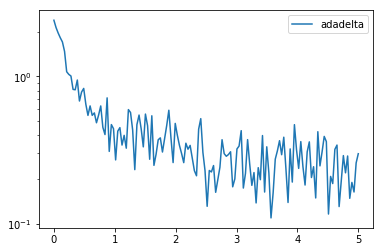

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
x_axis = np.linspace(0, 5, len(train_losses), endpoint=True)
plt.semilogy(x_axis, train_losses, label='adadelta')
plt.legend(loc='best')

In [9]:
train_op = tf.train.AdamOptimizer(1e-3).minimize(loss)

In [10]:
sess.run(tf.global_variables_initializer())

batch_size = 64
train_losses2 = []

epoch = 0
sample_passed = 0
epoch_done = False
step = 0

_start = time.time()

while(epoch < 5):
    if sample_passed + batch_size >= mnist.train.num_examples:
        this_batch = mnist.train.num_examples - sample_passed
        sample_passed =0
        epoch +=1
        epoch_done = True
    else:
        sample_passed += batch_size
        this_batch = batch_size
    images, labels = train_set.next_batch(this_batch)
    
    if epoch_done:
        train_loss = []
        train_acc = []
        for _ in range(train_set.num_examples // 100):
            image, label = train_set.next_batch(100)
            loss_train, acc_train = sess.run([loss,acc], feed_dict={input_ph: image, label_ph: label})
            #print(acc_train)
            train_acc.append(acc_train)
            train_loss.append(loss_train)
        #print(train_acc)
        print('Epoch{}: Trian loss: {:.6f} Accuracy: {:.6f}'.format(epoch, np.array(train_loss).mean(),
                                                                    np.array(train_acc).mean()))
        
        epoch_done = False
    
    if step % 30 == 0:
        loss_train = sess.run(loss, feed_dict={input_ph: images, label_ph: labels})
        train_losses2.append(loss_train)
    sess.run(train_op, feed_dict={input_ph: images, label_ph: labels})
    step +=1
_end = time.time()
print("Train done ! Cost Time: {:.2f}".format(_end - _start))
            

Epoch1: Trian loss: 0.087573 Accuracy: 0.974146
Epoch2: Trian loss: 0.050304 Accuracy: 0.983855
Epoch3: Trian loss: 0.041743 Accuracy: 0.986582
Epoch4: Trian loss: 0.036232 Accuracy: 0.988545
Epoch5: Trian loss: 0.023441 Accuracy: 0.992145
Train done ! Cost Time: 22.13
